This script will
- Get data from stations
- Get processed altimeter data
- Plot data location
- Plot time series altimeter and station
- Calculate and Plot accuracies
- Separate low level from high levels

In [3]:
from ground_data import GroundObservations
from ts_preprocesing import *#get_date_time_cols
import scipy.interpolate as sc
import geopandas as gpd
from timezonefinder import TimezoneFinder
# from ts_preprocesing import convert_units
import importlib
import pandas as pd
import os
import datetime as dt
import numpy as np
%load_ext autoreload
%autoreload 2

In [123]:
#Test Getting data from stations
#So far what works
# Getting locss stations
# Getting ARHN stations 
# Getting USGS stations from file. Still working on R script connection
go=GroundObservations()

lc_lakes=['KHB2','HMT2','PHN2','SAW2','RAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','MAB2']
#df_locss=go.read_ground_data('LOCSS', station_id=lc_lakes)
#df_locss=get_date_time_cols(df_locss, 'date', has_hour=True)
#stations=df_locss['gauge_id'].unique()
#height_fd='height'
#df_final=convert_units(df_locss,height_fd, origin='FEET', to='METER', check_col=True, unit_fd='unit',
#                   gauge_fd='gauge_id')
# print(df_final.columns)
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(style='whitegrid')

# sns.displot(data=df_final, x='height', col='gauge_id')
# sns.displot(data=df_locss, x='height', col='gauge_id')

##ar_lakes=['1805', '1819', '1824', '2830', '1830','2832', '2028','2102','2231','2234','2300','2316']
##'2102' Is a meteorlogical station 

ar_lakes=['1805', '1819', '1824', '2830', '1830','2832', '2028','2231','2234','2300','2316']
skip_rows=1

#df_arhn=go.read_ground_data('ARHN', skip_rows=skip_rows, station_id=ar_lakes)
# df_arhn=get_date_time_cols(df_arhn, 'date', has_hour=True)
## print(df_arhn.columns)
## print(df_arhn.gauge_id.unique())
## print('/n..................../n',df_arhn.head(2))

# us_lakes=['2464800','6903880','6604000']
# df_usgs=go.read_ground_data('USGS',station_id=us_lakes)
# df_usgs=get_date_time_cols(df_usgs, 'date')

rvbr_lakes=['19069','19060','19126']
df_rvbr=go.read_ground_data('RVBR', station_id=rvbr_lakes)
df_rvbr=get_date_time_cols(df_rvbr,'date')
df_rvbr
# df_rvbr.gauge_id.unique()
# print(df_usgs.columns)

#falta Brazil
# df['file_name'].str.split('_', expand=True)


19069 ['br_19069_MACHADINHO.xlsx']
19060 ['br_19060_SEGREDO.xlsx']
19126 ['br_19126_XINGO.xlsx']


gauge_id        Nome  height Afluência (m³/s) Defluência (m³/s)  \
0       19069  MACHADINHO     NaN           151,59            151,59   
1       19069  MACHADINHO     NaN           154,87            154,87   
2       19069  MACHADINHO     NaN           220,59            220,59   
3       19069  MACHADINHO     NaN           431,79            431,79   
4       19069  MACHADINHO     NaN           308,63            308,63   
...       ...         ...     ...              ...               ...   
8128    19126       XINGO  137,56          1641,00           1852,00   
8129    19126       XINGO  137,64          1763,00           1832,00   
8130    19126       XINGO  137,59          1812,00           1939,00   
8131    19126       XINGO  137,41          1822,00           1926,00   
8132    19126       XINGO     NaN              NaN               NaN   

     Vazão Vertida (m³/s) Vazão Turbinada (m³/s) Vazão Natural (m³/s)  \
0                     NaN                    NaN               154,02   
1                     NaN                    NaN               157,28   
2                     NaN                    NaN               222,97   
3                     NaN                    NaN               434,14   
4                     NaN                    NaN               310,95   
...                   ...                    ...                  ...   
8128                 0,00                1852,00              4371,00   
8129                 0,00                1832,00              4052,00   
8130                 0,00                1939,00              3703,00   
8131                 0,00                1926,00              3436,00   
8132                  NaN                    NaN              3238,00   

     Volume Útil (%) Vazão Incremental (m³/s)       date source  year  month  \
0                NaN                      NaN 2000-01-01   RVBR  2000      1   
1                NaN                      NaN 2000-01-02   RVBR  2000      1   
2                NaN                      NaN 2000-01-03   RVBR  2000      1   
3                NaN                      NaN 2000-01-04   RVBR  2000      1   
4                NaN                      NaN 2000-01-05   RVBR  2000      1   
...              ...                      ...        ...    ...   ...    ...   
8128             NaN                      NaN 2022-04-03   RVBR  2022      4   
8129             NaN                      NaN 2022-04-04   RVBR  2022      4   
8130             NaN                      NaN 2022-04-05   RVBR  2022      4   
8131             NaN                      NaN 2022-04-06   RVBR  2022      4   
8132             NaN                      NaN 2022-04-07   RVBR  2022      4   

      day  hour    decimal_y  
0       1    12  2000.001366  
1       2    12  2000.004098  
2       3    12  2000.006831  
3       4    12  2000.009563  
4       5    12  2000.012295  
...   ...   ...          ...  
8128    3    12  2022.253425  
8129    4    12  2022.256164  
8130    5    12  2022.258904  
8131    6    12  2022.261644  
8132    7    12  2022.264384  

[24396 rows x 17 columns]

In [124]:
#Relevant columns
# df_ground_ts=pd.DataFrame()
common_cols=['gauge_id','source','decimal_y','height','date','year', 'month', 'day', 'hour']
df_usgs[common_cols]
df_ground_ts=pd.concat((df_usgs[common_cols].copy(),df_arhn[common_cols].copy(), df_final[common_cols].copy(), df_rvbr.copy()), axis=0)
# pd.datetime(+pd.to_datetime(df_final['time'], format='%H:%M:%S'), format='%Y-%m-%d %H:%M:%S')

In [126]:
# df_ground_ts.loc[df_ground_ts['gauge_id']=='WEW2'].plot('date','height')
altis_w_gts_csv

lon        lat                                 altivs_nam source  \
0   -71.600774 -41.286871    AlTiS_TimeSeries_Sentinel-3A_0562_S4128   ARHN   
1   -71.498490 -40.166730    AlTiS_TimeSeries_Sentinel-3A_0749_S4016   ARHN   
2   -71.543530 -40.173470        AlTiS_TimeSeries_Jason-3_0215_S4017   ARHN   
3   -71.627499 -40.167500  AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017   ARHN   
4   -71.362723 -43.249475    AlTiS_TimeSeries_Sentinel-3A_0635_S4324   ARHN   
5   -71.362723 -43.249475    AlTiS_TimeSeries_Sentinel-3A_0676_S4325   ARHN   
6   -71.508490 -44.923180    AlTiS_TimeSeries_Sentinel-3B_0020_S4492   ARHN   
7   -78.412410  34.669780    AlTiS_TimeSeries_Sentinel-3B_0691_N3466  LOCSS   
8   -77.097071  34.931964    AlTiS_TimeSeries_Sentinel-3A_0035_N3493  LOCSS   
9  -113.097640  53.461420    AlTiS_TimeSeries_Sentinel-3A_0351_N5346  LOCSS   
10   89.145590  22.948660    AlTiS_TimeSeries_Sentinel-3A_0522_N2294  LOCSS   
11  -76.406140  35.778110    AlTiS_TimeSeries_Sentinel-3A_0149_N3577  LOCSS   
12  -88.179050  41.940260    AlTiS_TimeSeries_Sentinel-3B_0622_N4194  LOCSS   
13 -122.295340  48.148160    AlTiS_TimeSeries_Sentinel-3B_0026_N4814  LOCSS   
14 -122.072630  47.566010    AlTiS_TimeSeries_Sentinel-3A_0026_N4756  LOCSS   
15   41.834339 -88.174629    AlTiS_TimeSeries_Sentinel-3B_0549_N4183  LOCSS   
16 -120.798073  47.827401    AlTiS_TimeSeries_Sentinel-3A_0637_N4783  LOCSS   
17   42.340871 -88.045794    AlTiS_TimeSeries_Sentinel-3B_0622_N4234  LOCSS   
18   91.099150  25.153220    AlTiS_TimeSeries_Sentinel-3A_0193_N2515  LOCSS   
19   91.137042  25.133184    AlTiS_TimeSeries_Sentinel-3A_0193_N2515  LOCSS   
20  -52.136790 -25.885350    AlTiS_TimeSeries_Sentinel-3A_0076_S2588   RVBR   
21  -52.013800 -25.996900        AlTiS_TimeSeries_Jason-3_0011_S2599   RVBR   
22  -37.948950  -9.533100    AlTiS_TimeSeries_Sentinel-3A_0560_S0953   RVBR   
23  -51.626360 -27.516310    AlTiS_TimeSeries_Sentinel-3A_0190_S2751   RVBR   
24  -87.604540  33.387080    AlTiS_TimeSeries_Sentinel-3A_0194_N3338   USGS   
25  -95.117320  43.482560    AlTiS_TimeSeries_Sentinel-3B_0480_N4348   USGS   
26  -92.985950  40.863730    AlTiS_TimeSeries_Sentinel-3A_0635_N4086   USGS   

   station_id                                              Notes  \
0        1824                                           Mascardi   
1        2028                                              Lacar   
2        2028                                              Lacar   
3        2028                             Lacar. Extended series   
4        2234                                            Rosario   
5        2234                                                NaN   
6        2316                                                NaN   
7        BTN2                                                NaN   
8        CFN2                                            Catfish   
9        HMT2                                                NaN   
10       KHB2                                                NaN   
11       PHN2                                                NaN   
12       QUL2                                                NaN   
13       RAW2                                                NaN   
14       SAW2                                                NaN   
15       SLL2                                        Sylver lake   
16       WEW2                                          Wenatchee   
17       YSL2                                         Grays Lake   
18       TAB2  Tanguar Haor (Confirm, it see lakes are fully ...   
19       MAB2                 Matian Haor. Lake gauge is at 4km    
20      19060                                            Segredo   
21      19060                                            Segredo   
22      19126                                              xingo   
23      19069                                         MACHADINHO   
24    2464800                                                NaN   
25    6604000                 

In [56]:
def open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti=-9999):
    #Read altis
    (altiyear, altimonth, altiday, altihour, altiminute, altiwelev)=load_altis(g_path+altis_name+'.csv', 
                                                                               altis_date_fd, altis_height_fd, nodataalti=-9999)
    # Compute decimal year from year/month/day from altimetry time series
    altidy = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                           altiyear, altimonth, altiday, altihour,
                           altiminute, np.zeros(altiday.shape))))
    
    dic_altis={'decimal_y':altidy,'height':altiwelev,'year':altiyear, 'month':altimonth, 'day':altiday, 'hour':altihour}
    
    df_altis=pd.DataFrame(dic_altis)
    df_altis['name_altis']=altis_name
    df_gts_st=df_gts.loc[df_gts[st_fd]==st_id].copy()
    
    return (df_altis, df_gts_st)

In [130]:
df_temp=df_ground_st.loc[df_ground_st['gauge_id']=='19060']
df_temp['date'].dt.tz_localize('America/Sao_Paulo').dt.tz_convert('utc')

NonExistentTimeError: 2000-10-08 00:00:00

Station America/Sao_Paulo 19060
Station America/Sao_Paulo 19060
Station America/Maceio 19126
Station America/Sao_Paulo 19069


<ipython-input-132-c4eb39587e8c>:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i, figsize=(20, 6))


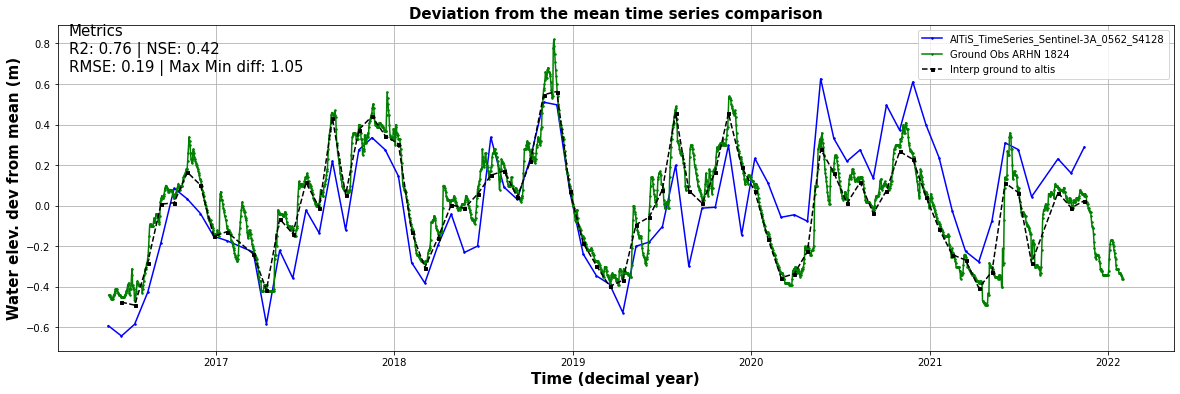

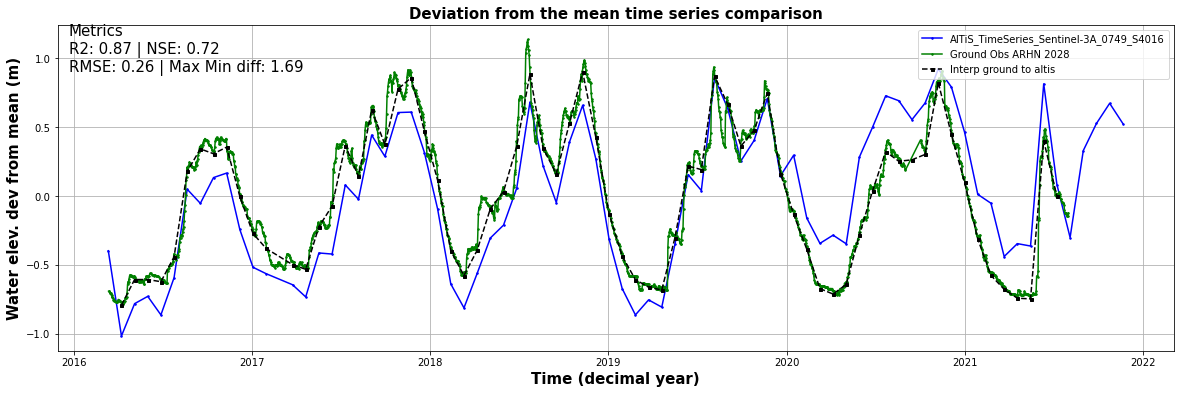

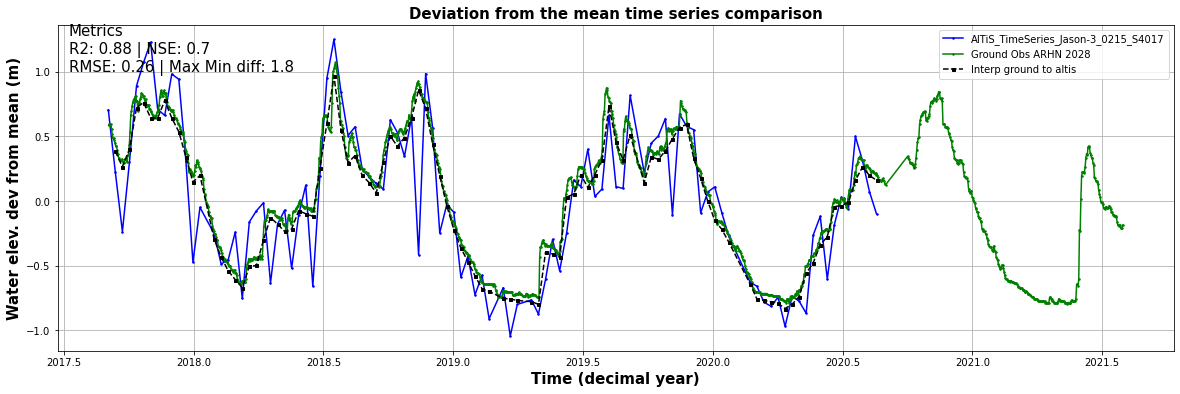

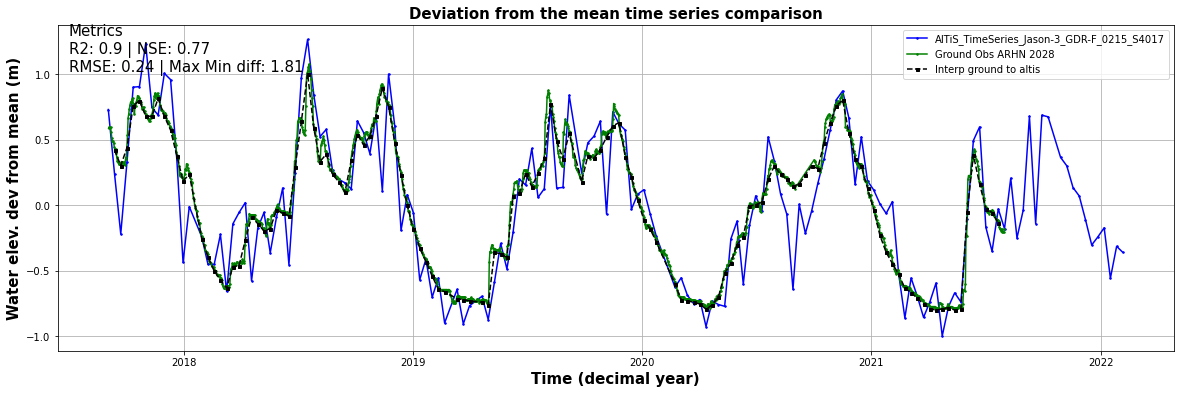

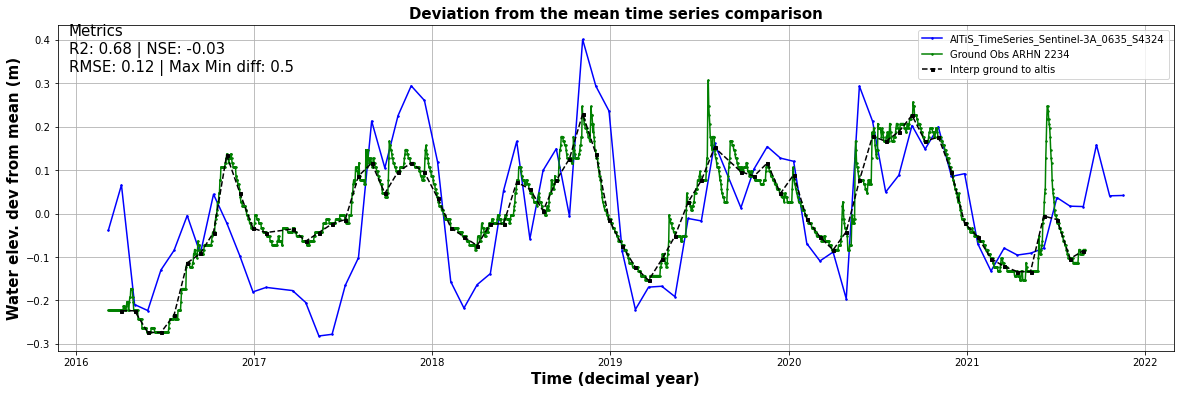

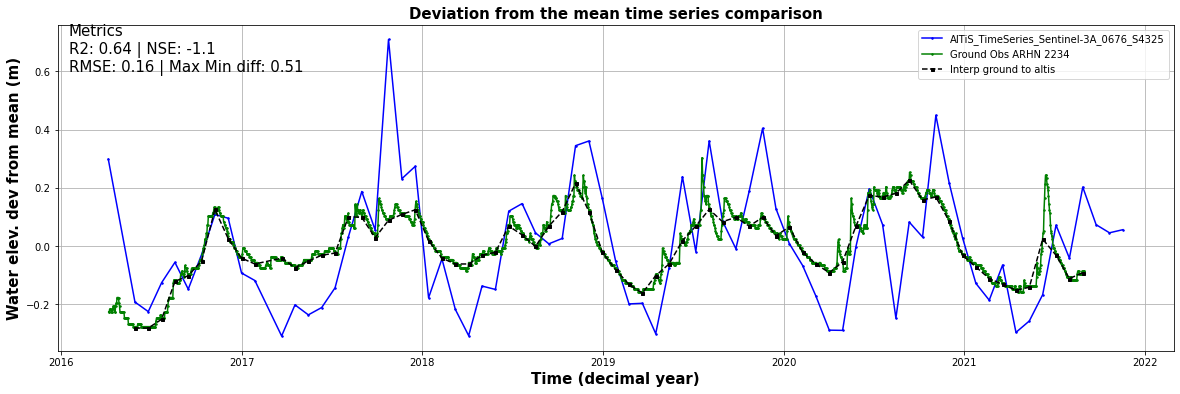

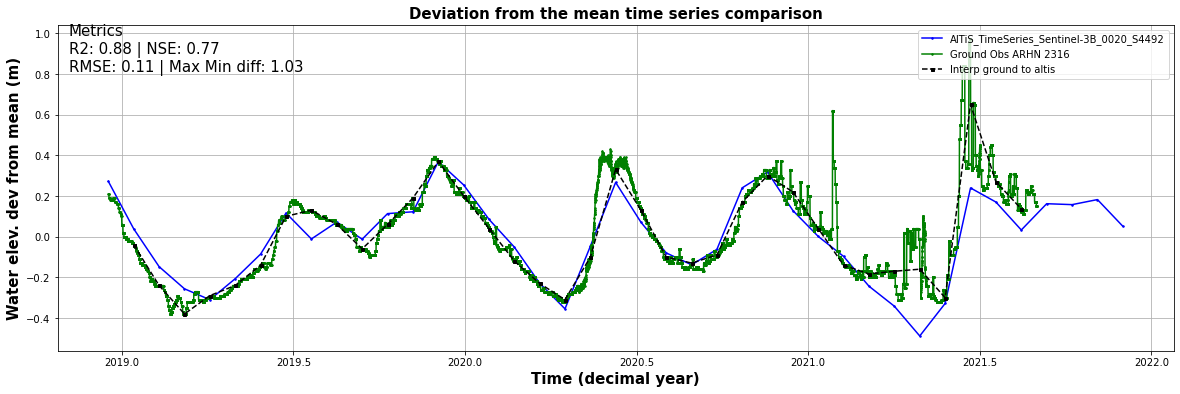

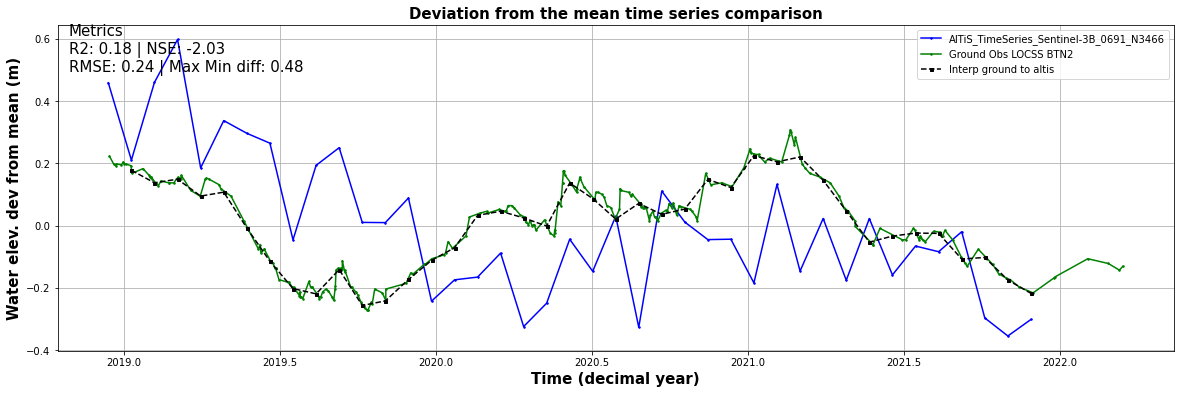

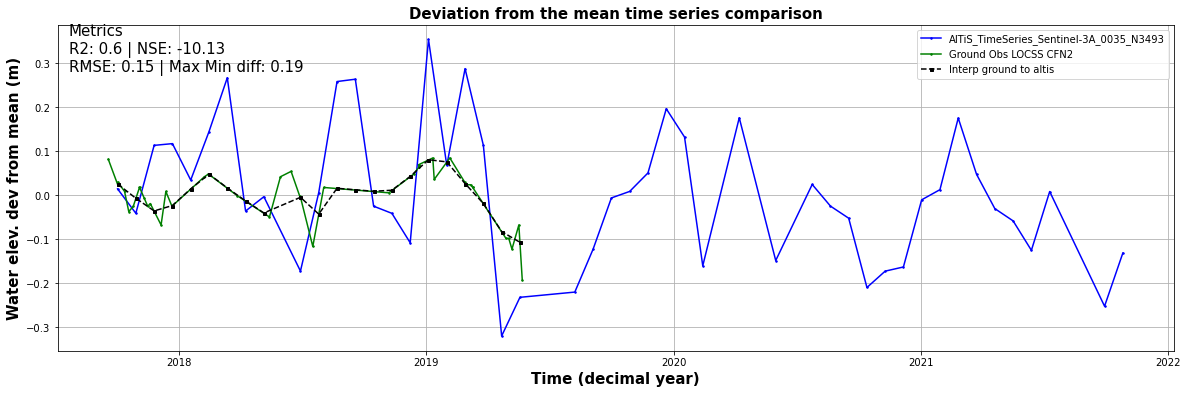

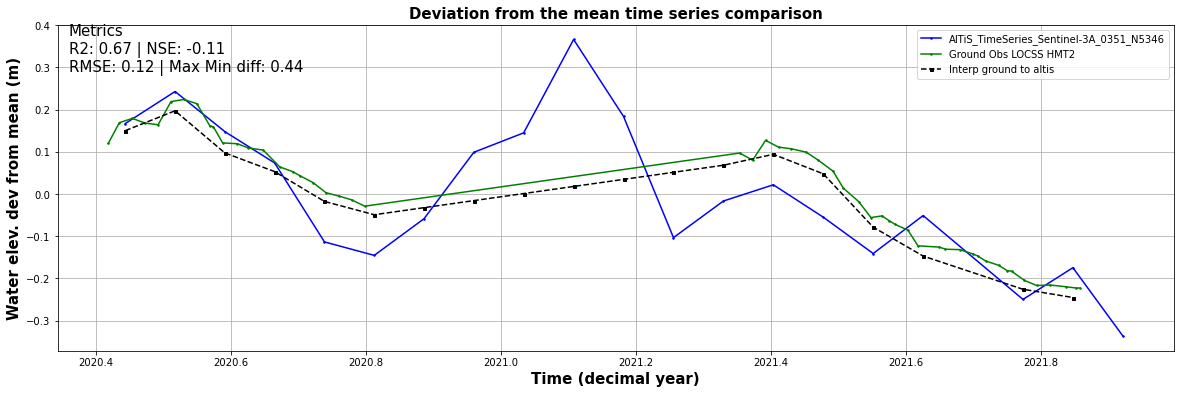

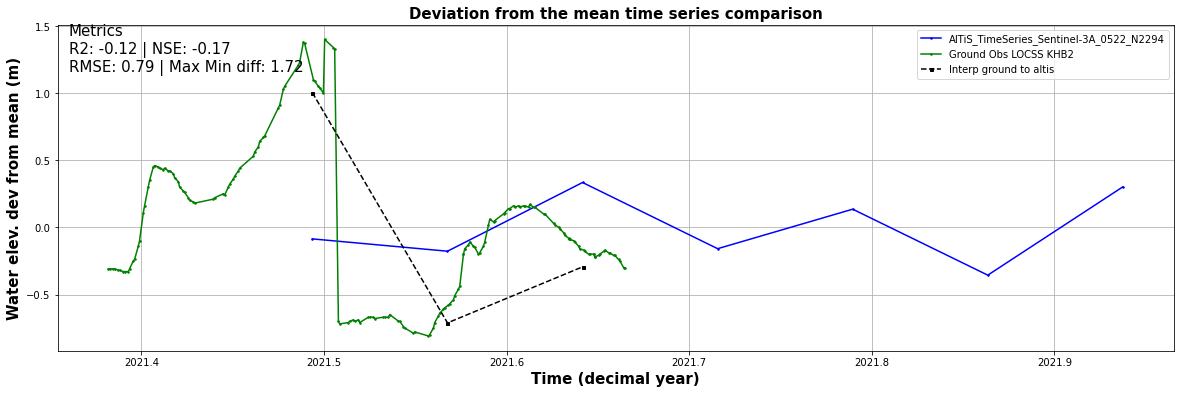

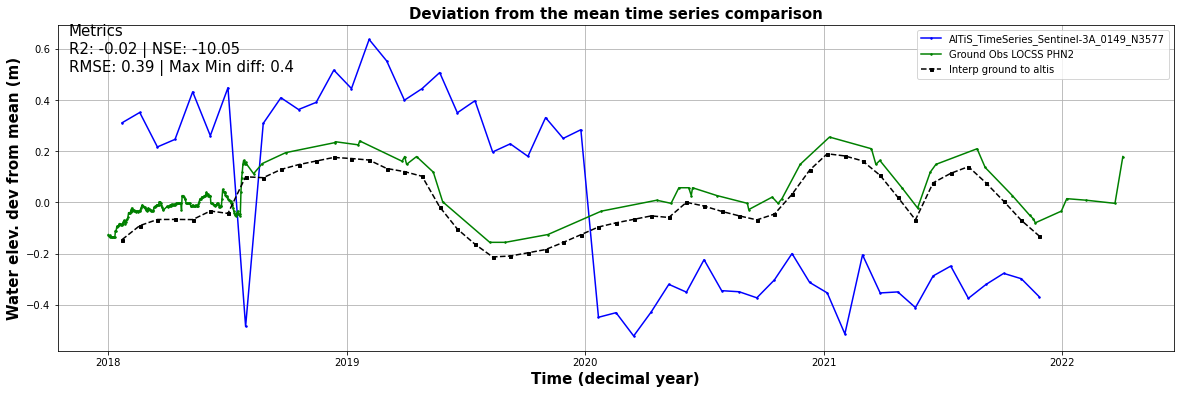

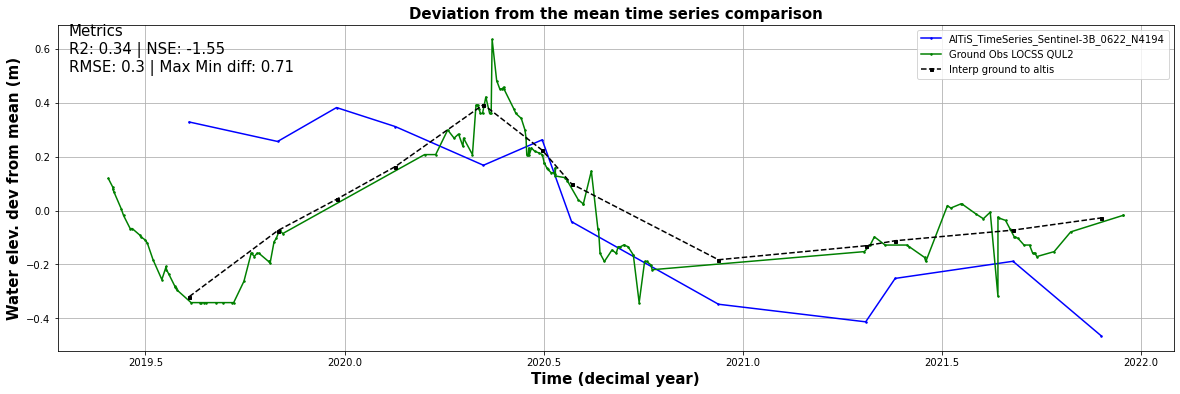

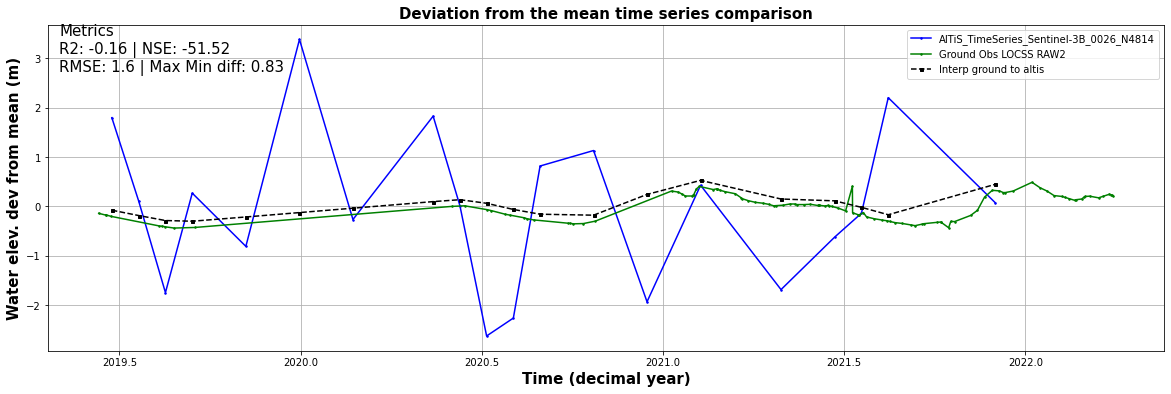

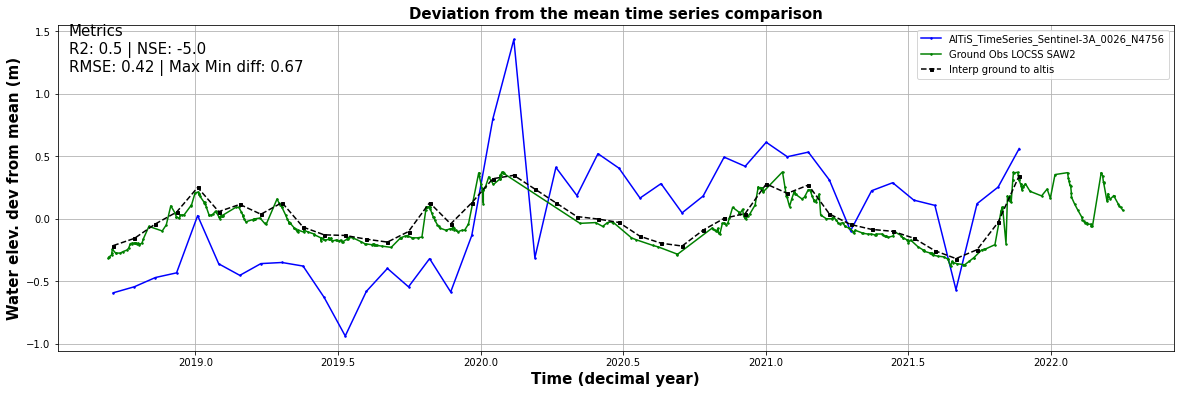

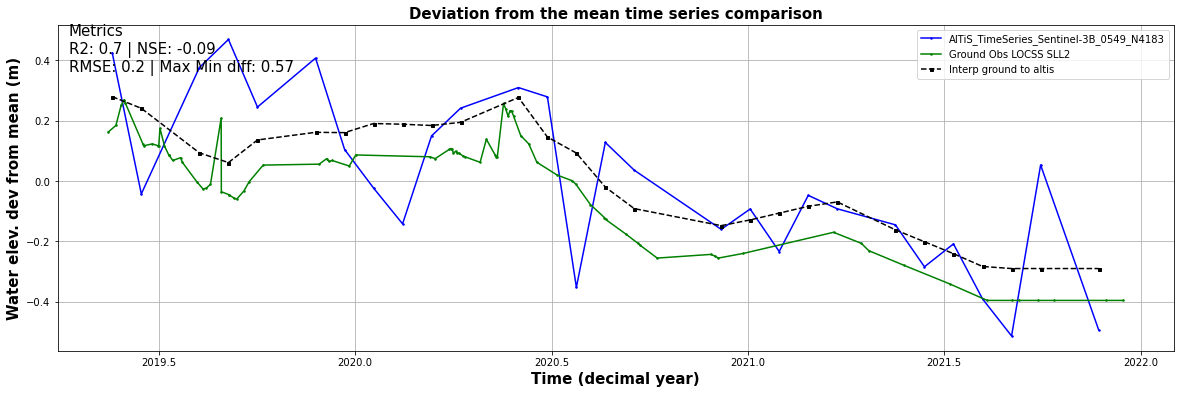

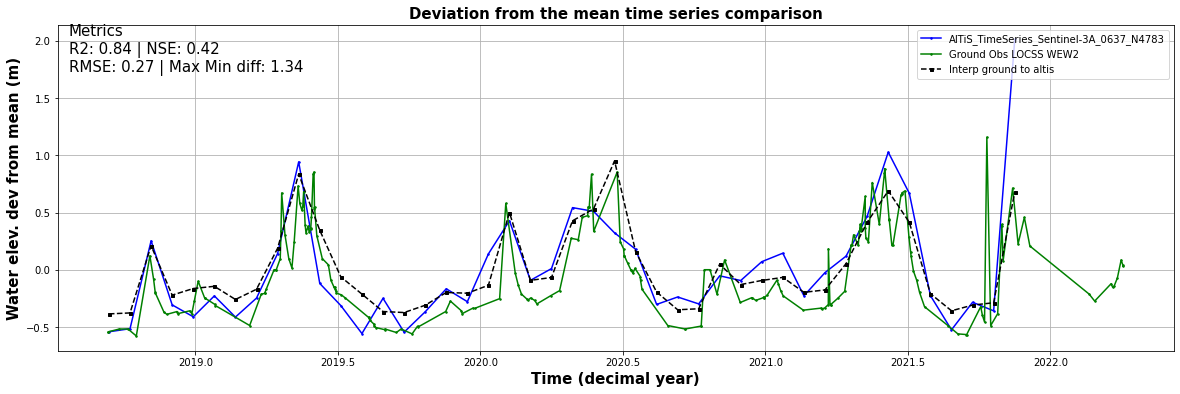

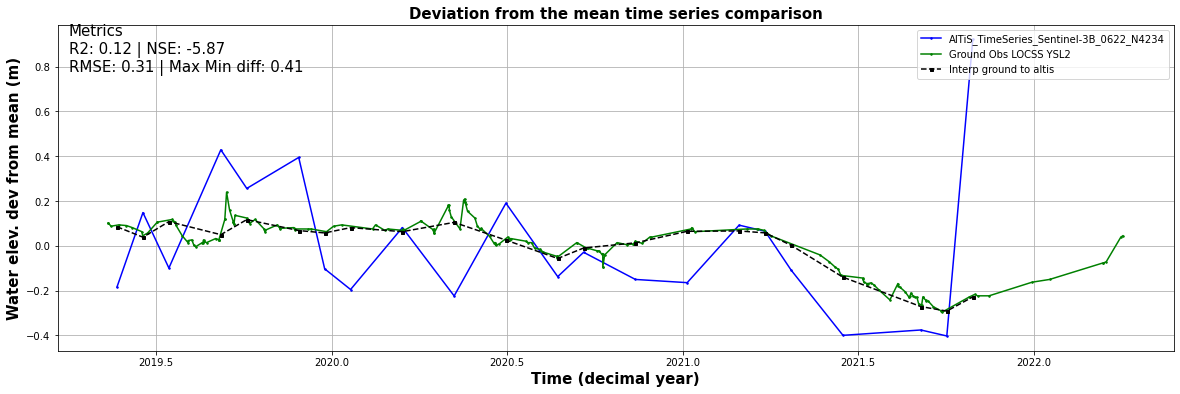

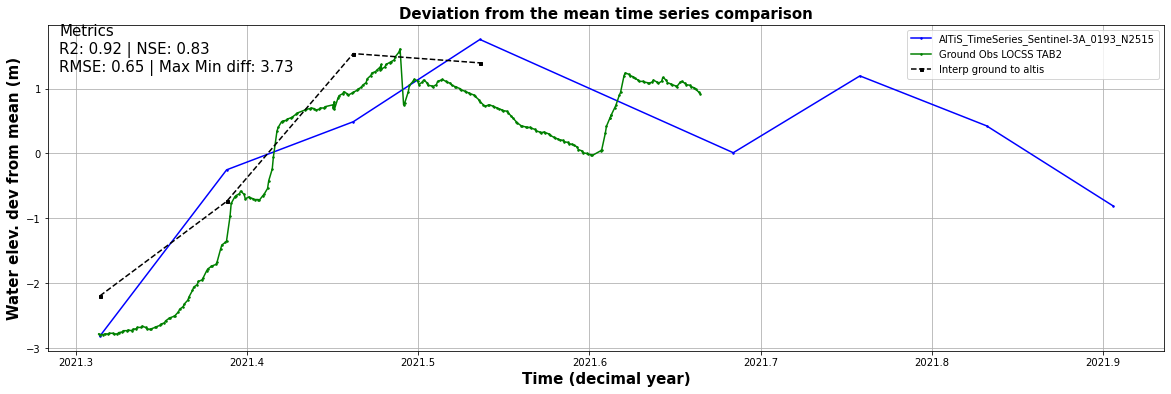

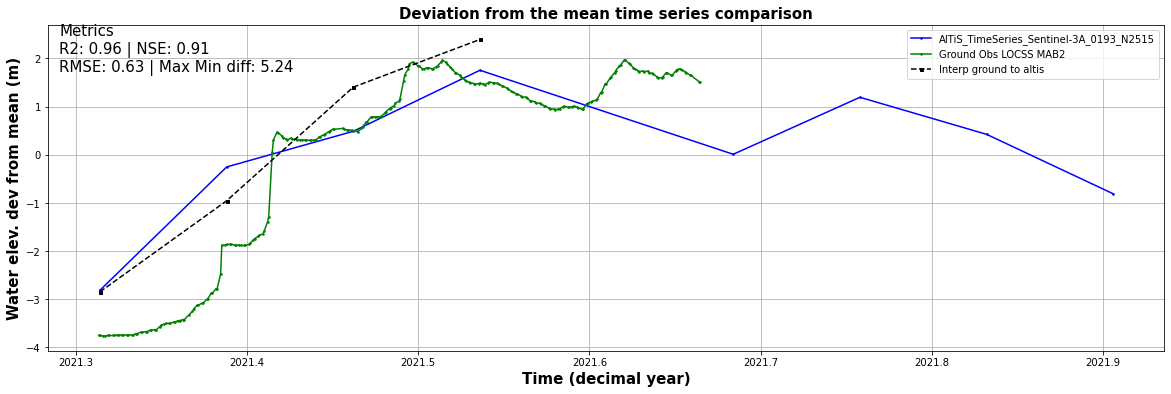

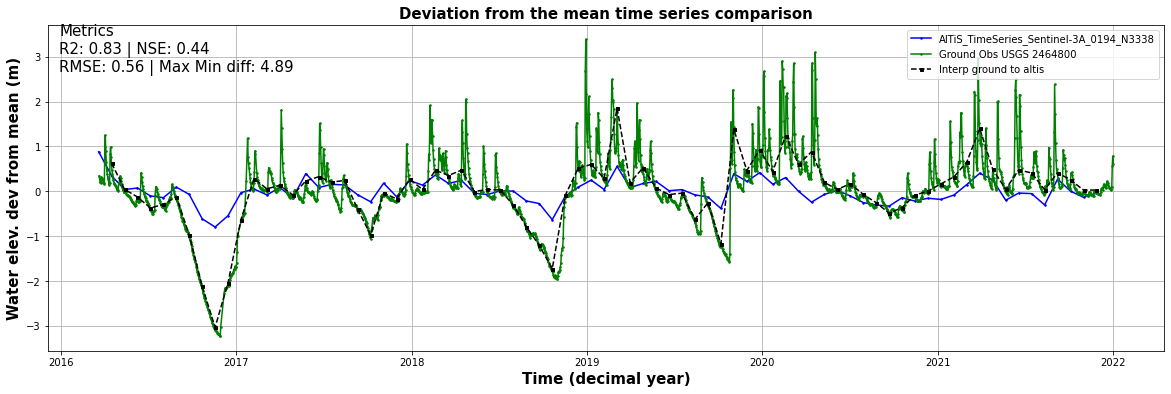

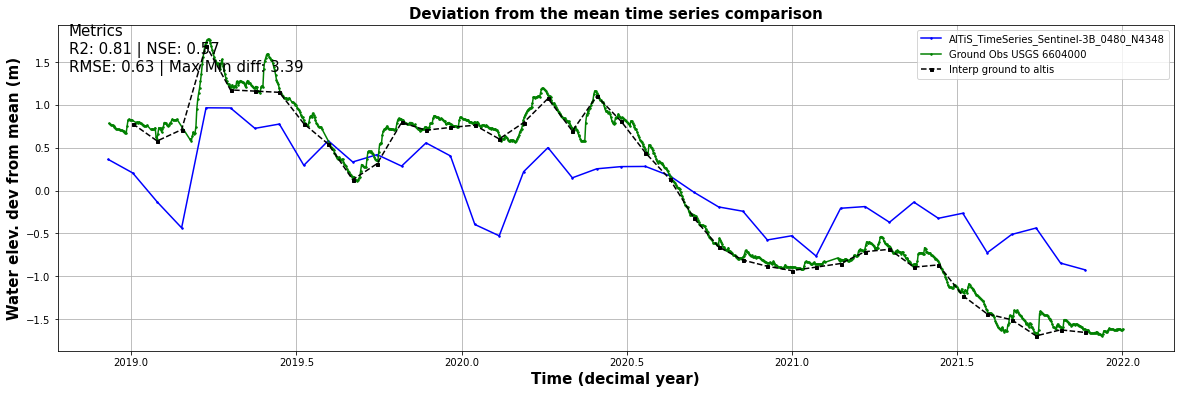

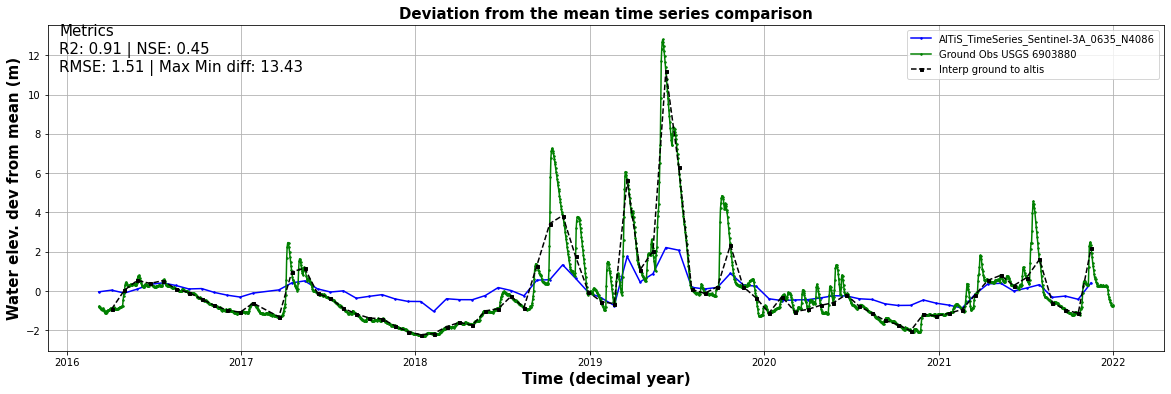

In [132]:
# #read all altiss 


# import geoplot as gplt
# #WRITE AS FUNCTIONS TO MOVE LATER
# #Read shapefile with all the coordinates and the id of the files
#path= '/home/angelica/Dropbox/Research/LOCSS/Denis_Sylvain/15_L_Altis_20220318/lonlat_vs_altis_ed.shp' When it is a shape file
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]
# print(altis_shp.shape)
# print(altis_w_gts_shp.shape)
# print(altis_w_gts_shp.columns)
# print(altis_csv.shape)
# print(altis_w_gts_csv.shape)
# print(altis_w_gts_csv.columns)

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
i=1
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()


for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    
    df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]
        if source=='RVBR':
            print('Station '+row['tz'], st_id)
            continue
            
        df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        # print(df_ground_st.head(), st_id)
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        if source=='USGS':
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=False)
        else:
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st=df_ground_st.sort_values(by=['decimal_y'])
        df_ground_st['altis_d_1']=altis_name

        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_st), axis=0)

        #Get the max and mins
        altis_min=df_altis['decimal_y'].min()
        ground_min=df_ground_st['decimal_y'].min()
        altis_max=df_altis['decimal_y'].max()
        ground_max=df_ground_st['decimal_y'].max()
        # print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        # print('\nAltis_max Ground_max: ',[altis_max, ground_max])
        #print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        if altis_min>ground_min:
            df_ground_plot=df_ground_st.loc[(df_ground_st['decimal_y']>=altis_min)]#&(df_ground_st['decimal_y']<altis_max)]
            df_altis_plot=df_altis
        else:
            df_ground_plot=df_ground_st
            df_altis_plot=df_altis.loc[(df_altis['decimal_y']>=ground_min)]#&(df_ground_st['decimal_y']<altis_max)]


        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_plot['decimal_y'].to_numpy(), df_ground_plot['height'].to_numpy(), 
                                          df_altis_plot['decimal_y'].to_numpy(), df_altis_plot['height'].to_numpy())

        error_m_text='\nR2: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'



        plt.figure(i, figsize=(20, 6))
        splot=plt.plot(df_altis_plot['decimal_y'], 
                       df_altis_plot['height']-np.nanmean(df_altis_plot['height']), '-bo', markersize=1.5, label=altis_name)
        gplot=plt.plot(df_ground_plot['decimal_y'], 
                       df_ground_plot['height']-df_ground_plot['height'].mean(), '-go', markersize=1.5, label='Ground Obs '+source+' '+st_id)
        iplot=plt.plot(df_altis_plot['decimal_y'].to_numpy(), 
                       inh_2_altidy-np.nanmean(inh_2_altidy), '--ks', markersize=3, label='Interp ground to altis')
        #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        ax=plt.gca()
        plt.text(0.01, 0.8, 'Metrics'+error_m_text, fontsize = 15, transform=ax.transAxes)
        plt.xlabel('Time (decimal year)', size=15, weight='bold')
        plt.ylabel('Water elev. dev from mean (m)', size=15, weight='bold')
        plt.grid('on')
        plt.legend(loc='upper right')
        plt.title('Deviation from the mean time series comparison', size=15,
                  weight='bold')
        plt.savefig('../data/plots/'+source+'_'+st_id+'_vs_'+altis_name+'.png',
                    bbox_inches='tight')

        # Plot time series
        #plt.figure(i+1, figsize=(20, 6))
        # jplot=plt.plot(altidy, altiwelev, '-bo', markersize=2.5, label='Jason-3_011_S2599')
        # splot=plt.plot(df_altis_plot['decimal_y'], 
        #                df_altis_plot['height'], '-go', markersize=1.5, label=altis_name)
        # gplot=plt.plot(df_ground_plot['decimal_y'], 
        #                df_ground_plot['height'], '-ro', markersize=1.5, label='Ground Obs '+st_id)
        # iplot=plt.plot(df_altis_plot['decimal_y'].to_numpy(), 
        #                 inh_2_altidy, '--ks', markersize=3, label='Interp ground to altis')
        # #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
        # plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        # plt.xlabel('Time (decimal year)', size=15, weight='bold')
        # plt.ylabel('Water elevation (m)', size=15, weight='bold')
        # plt.grid('on')
        # plt.legend()
        # plt.title('Water elevation (m)', size=15,
        #           weight='bold')
        # plt.savefig('../data/plots/'+source+'ground_interp_'+st_id+'_vs_'+altis_name+'.png',
        #              bbox_inches='tight')
        i=i+1
        
        
    
    #['gauge_id','source'
    
# def open_match__plot_station_altis(g_path,altis_name, st_id, df_gts, altis_date_fd, altis_height_fd, nodataalti=-9999):


<ipython-input-133-58e5424b45ad>:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i, figsize=(20, 6))


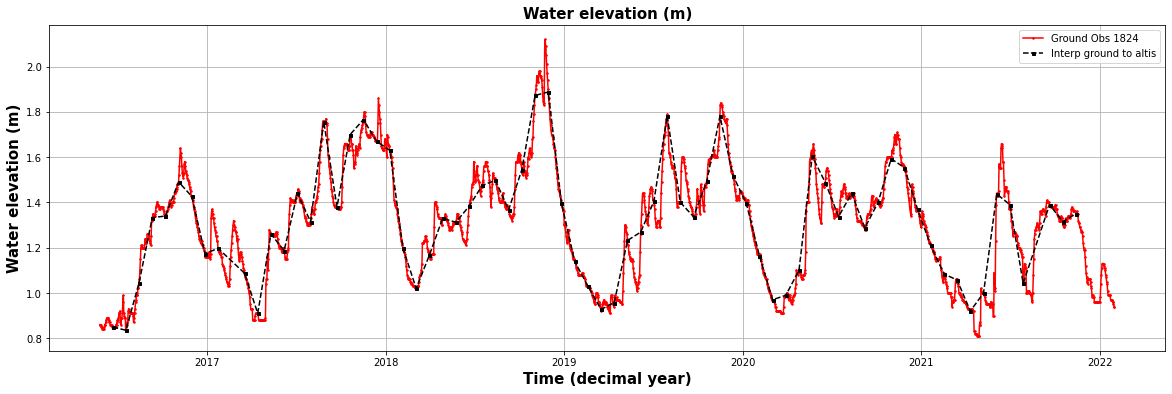

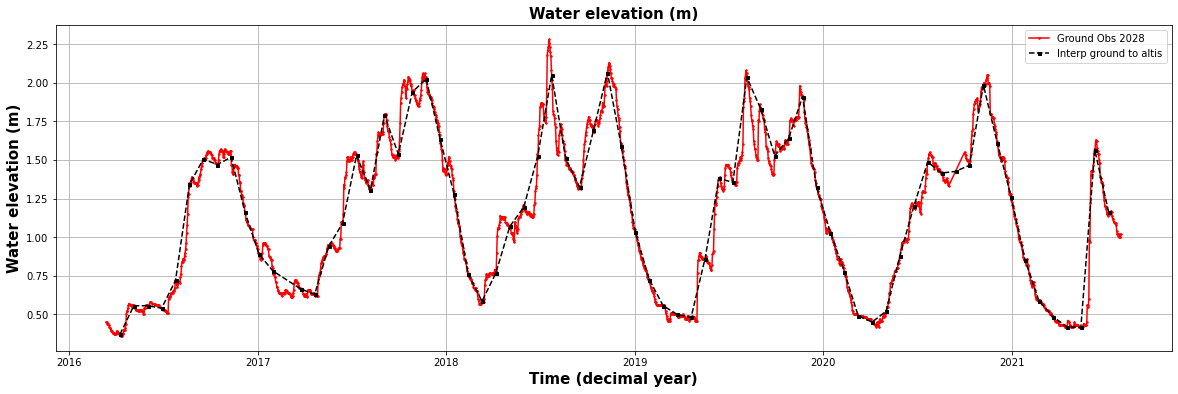

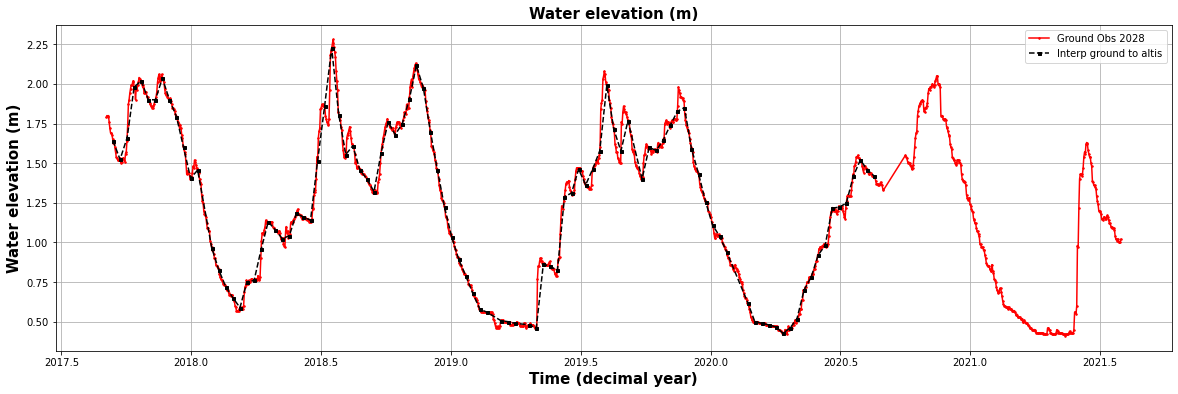

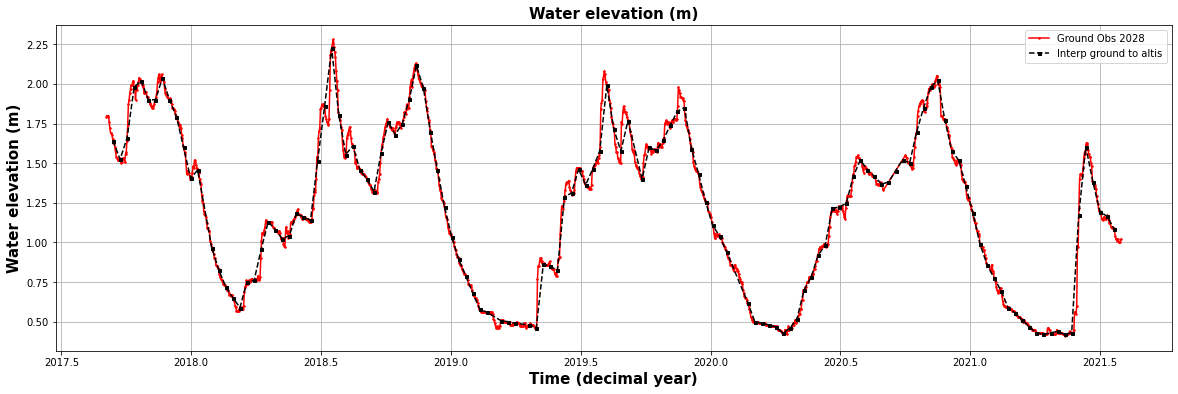

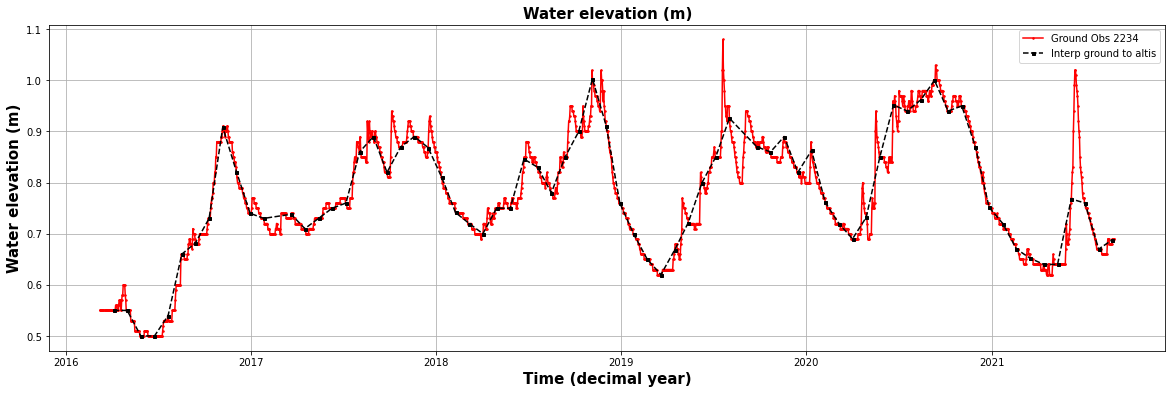

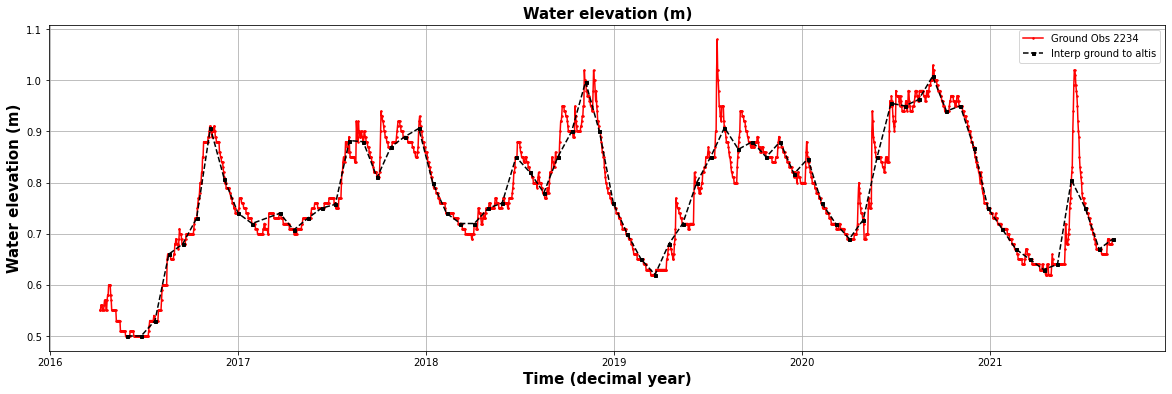

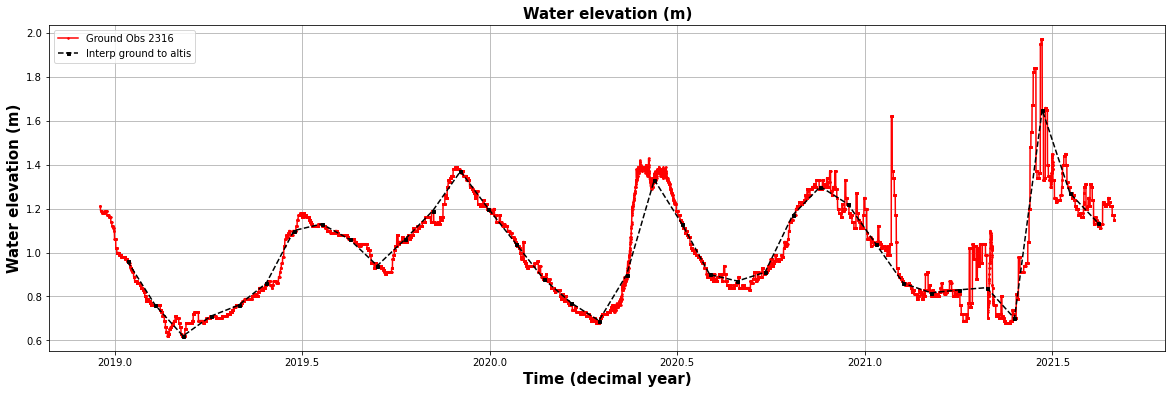

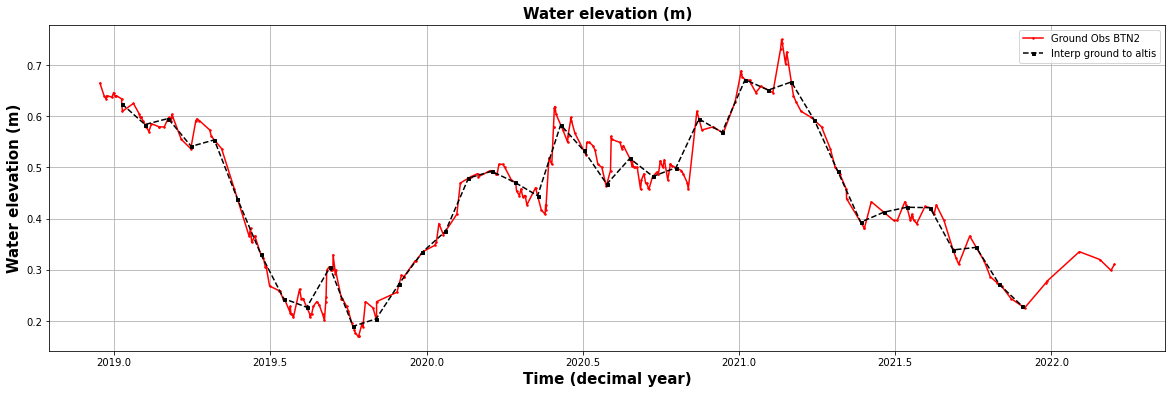

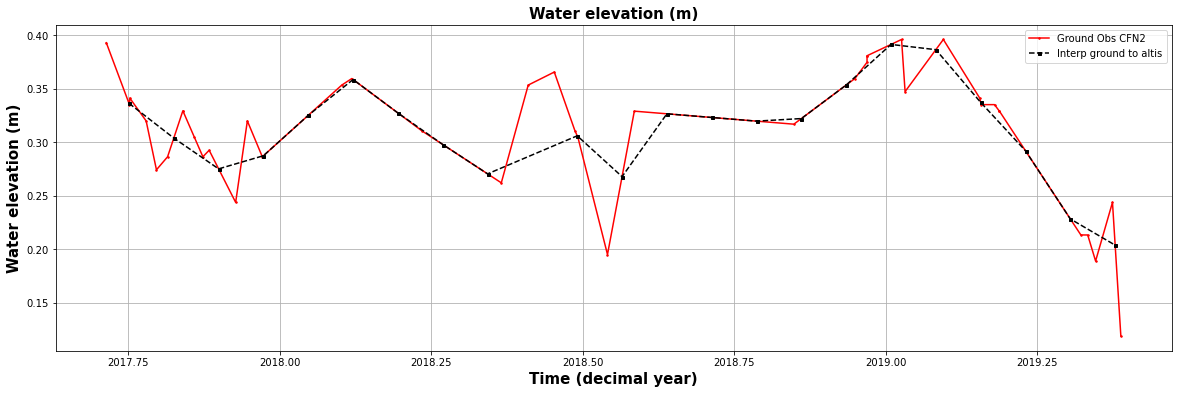

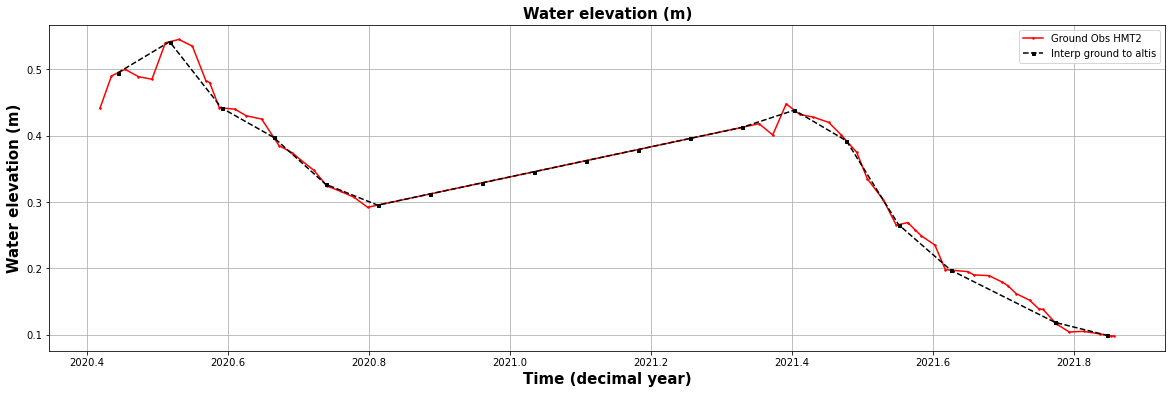

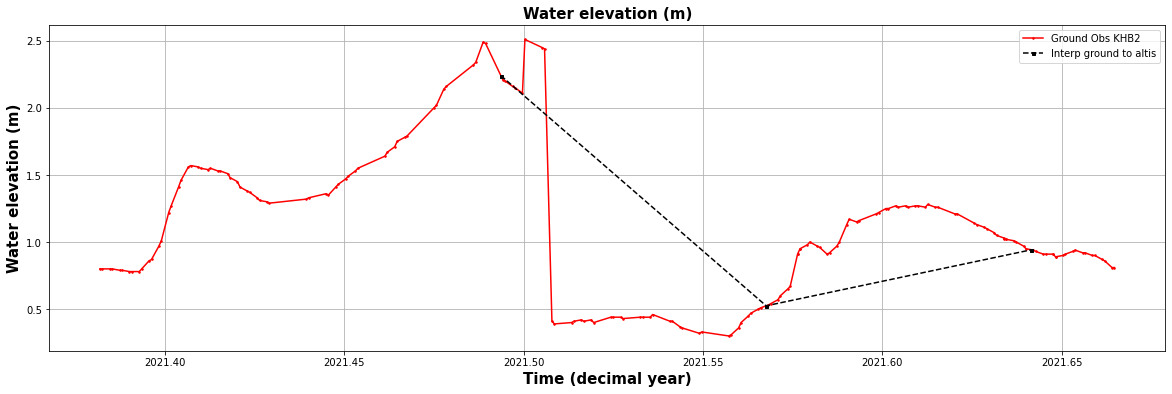

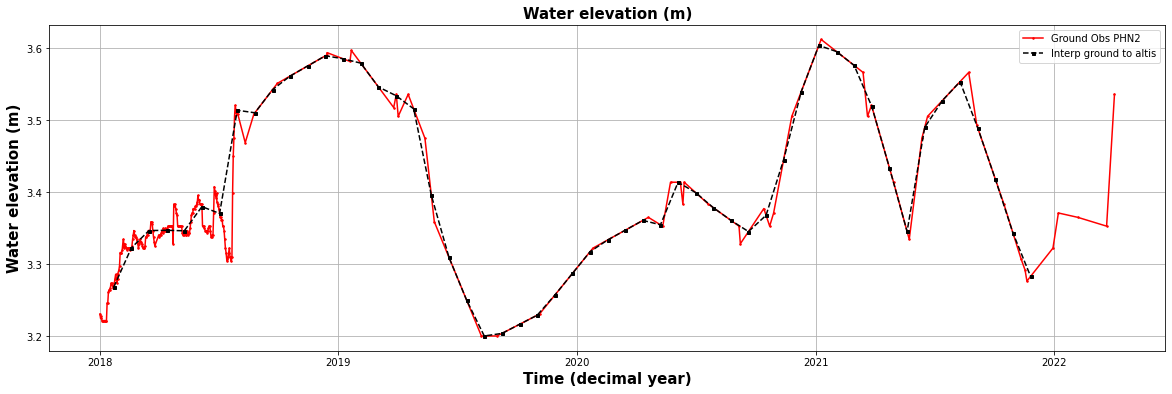

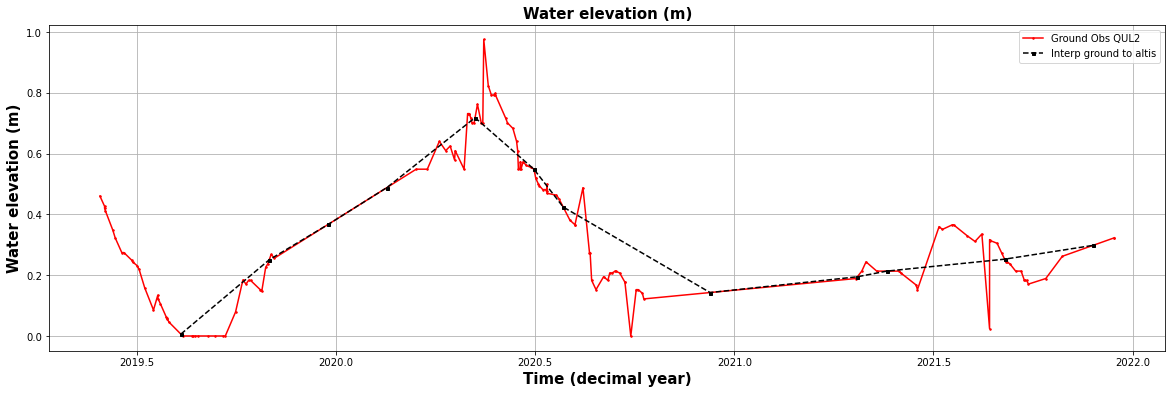

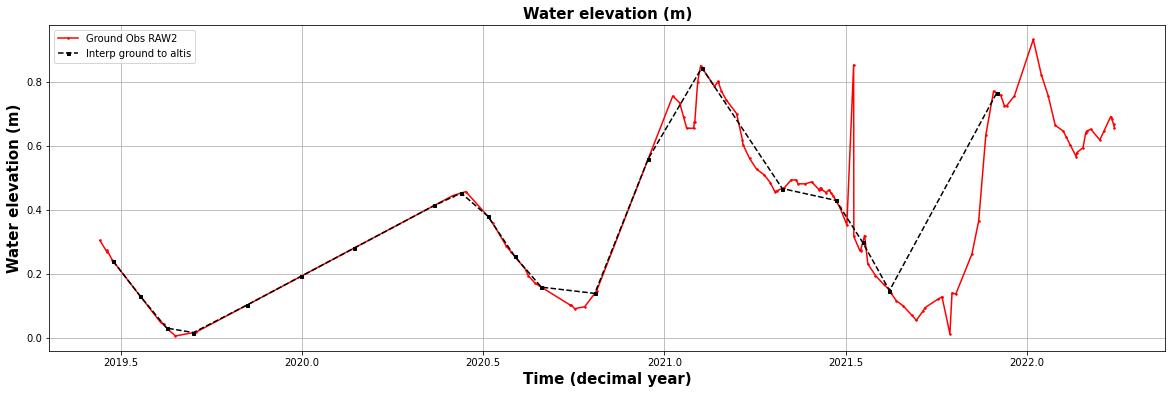

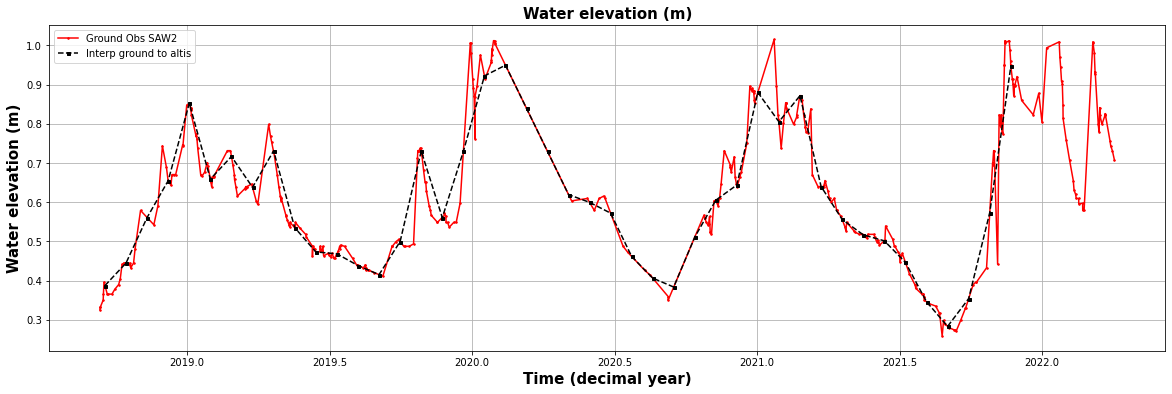

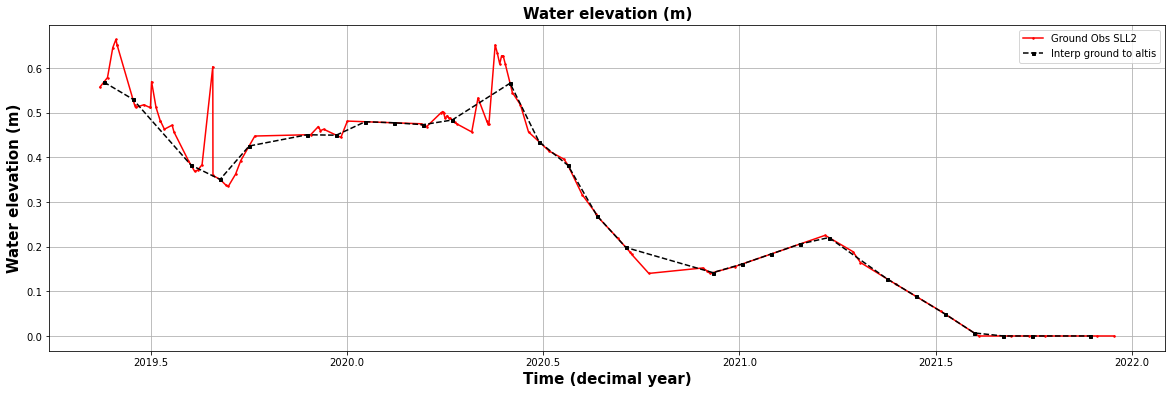

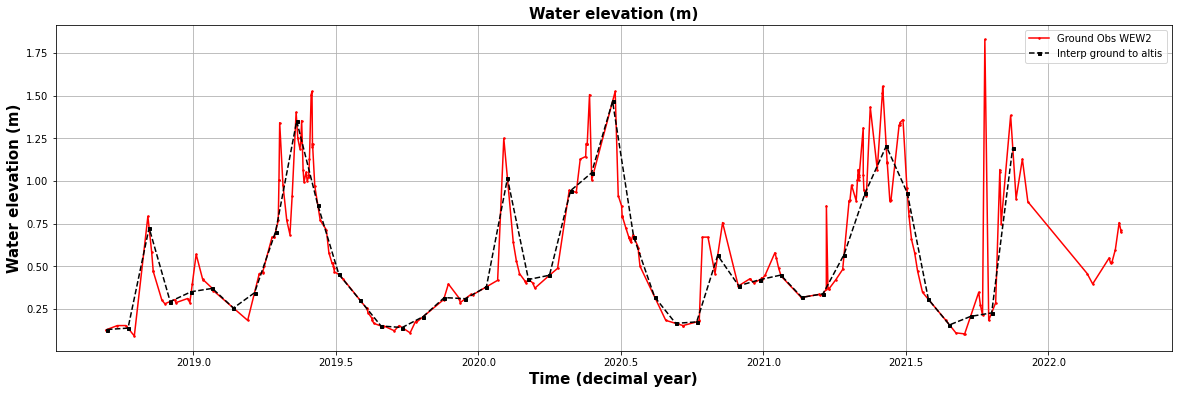

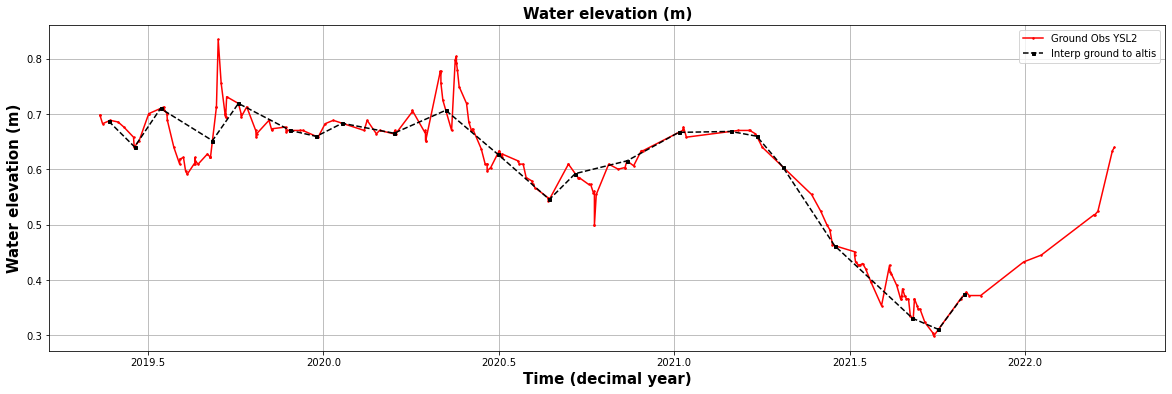

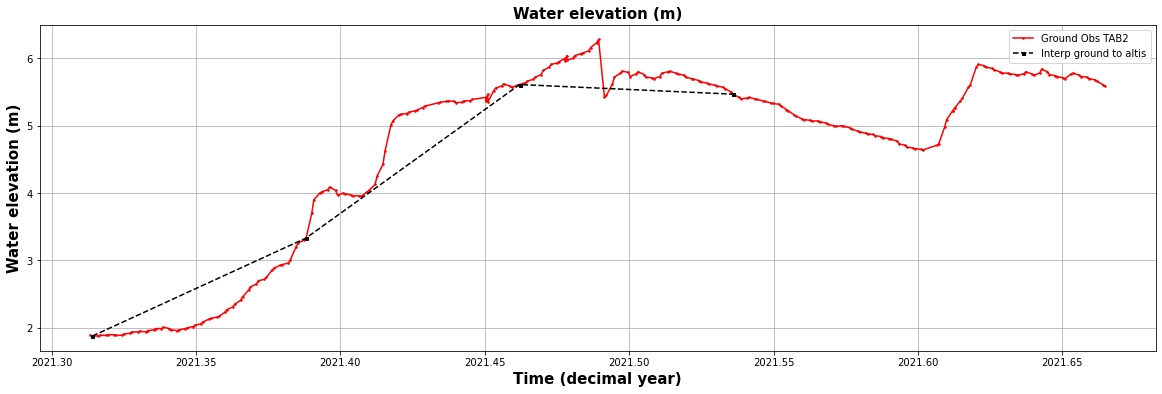

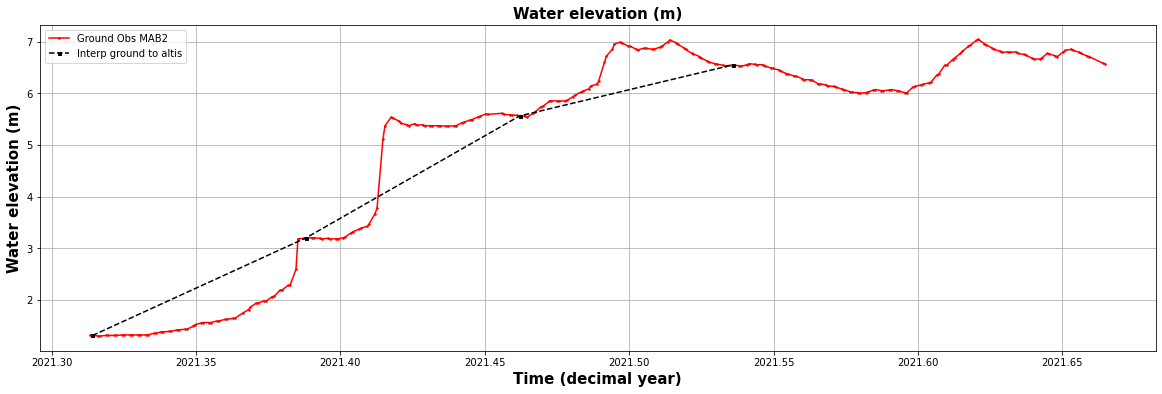

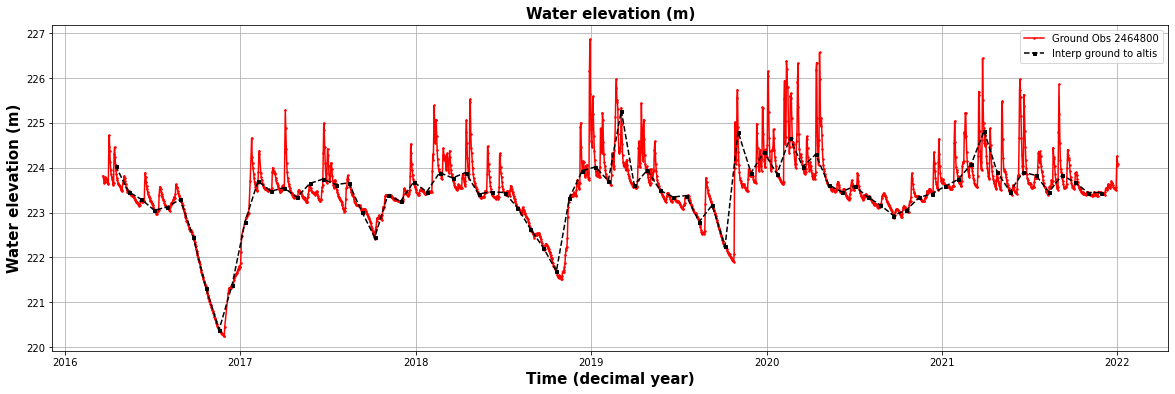

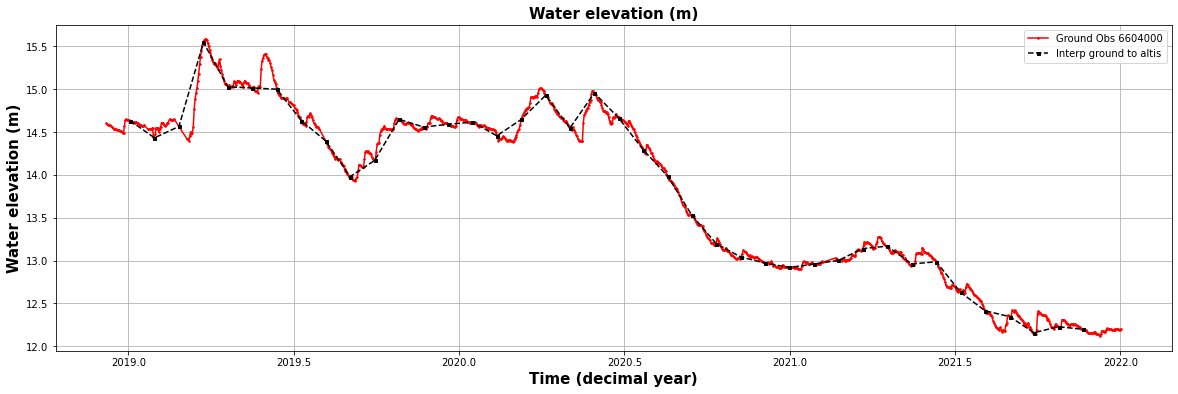

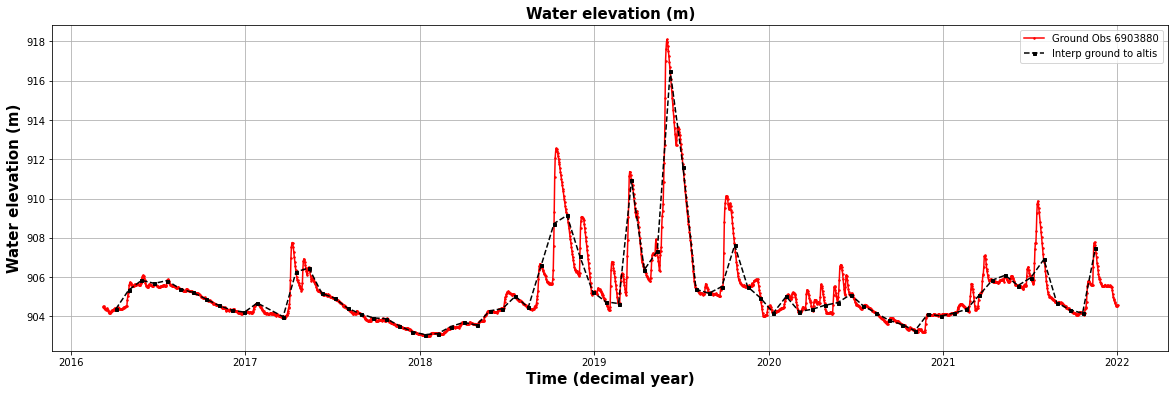

In [133]:
# #read all altiss 


# import geoplot as gplt
# #WRITE AS FUNCTIONS TO MOVE LATER
# #Read shapefile with all the coordinates and the id of the files
#path= '/home/angelica/Dropbox/Research/LOCSS/Denis_Sylvain/15_L_Altis_20220318/lonlat_vs_altis_ed.shp' When it is a shape file
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]
# print(altis_shp.shape)
# print(altis_w_gts_shp.shape)
# print(altis_w_gts_shp.columns)
# print(altis_csv.shape)
# print(altis_w_gts_csv.shape)
# print(altis_w_gts_csv.columns)

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
i=1
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    
    df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        source=df_ground_st['source'].iloc[0]
        if source=='RVBR':
            continue
        #Convert time in df_gts_st to UTC
        
        df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        #print(df_ground_st.head(), st_id)
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        if source=='USGS':
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=False)
        else:
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st=df_ground_st.sort_values(by=['decimal_y'])
        df_ground_st['altis_d_1']=altis_name

        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_st), axis=0)

        #Get the max and mins
        altis_min=df_altis['decimal_y'].min()
        ground_min=df_ground_st['decimal_y'].min()
        altis_max=df_altis['decimal_y'].max()
        ground_max=df_ground_st['decimal_y'].max()
        # print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        # print('\nAltis_max Ground_max: ',[altis_max, ground_max])
        #print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        if altis_min>ground_min:
            df_ground_plot=df_ground_st.loc[(df_ground_st['decimal_y']>=altis_min)]#&(df_ground_st['decimal_y']<altis_max)]
            df_altis_plot=df_altis
        else:
            df_ground_plot=df_ground_st
            df_altis_plot=df_altis.loc[(df_altis['decimal_y']>=ground_min)]#&(df_ground_st['decimal_y']<altis_max)]


        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_plot['decimal_y'].to_numpy(), df_ground_plot['height'].to_numpy(), 
                                          df_altis_plot['decimal_y'].to_numpy(), df_altis_plot['height'].to_numpy())

        error_m_text='\nR2: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'



        plt.figure(i, figsize=(20, 6))
        gplot=plt.plot(df_ground_plot['decimal_y'], 
                       df_ground_plot['height'], '-ro', markersize=1.5, label='Ground Obs '+st_id)
        iplot=plt.plot(df_altis_plot['decimal_y'].to_numpy(), 
                        inh_2_altidy, '--ks', markersize=3, label='Interp ground to altis')
        #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        plt.xlabel('Time (decimal year)', size=15, weight='bold')
        plt.ylabel('Water elevation (m)', size=15, weight='bold')
        plt.grid('on')
        plt.legend()
        plt.title('Water elevation (m)', size=15,
                  weight='bold')
        plt.savefig('../data/plots/'+source+'_ground_interp_'+st_id+'_vs_'+altis_name+'.png',
                     bbox_inches='tight')
        i=i+1
        
        
    
    #['gauge_id','source'
    
# def open_match__plot_station_altis(g_path,altis_name, st_id, df_gts, altis_date_fd, altis_height_fd, nodataalti=-9999):


In [25]:
df_locss.loc[df_locss['gauge_id']=='QUL2']

Empty DataFrame
Columns: [gauge_id, name, date, time, height, is_bubble_level_okay, notes, phone_no, min_height, max_height, unit, source, year, month, day, hour, decimal_y]
Index: []

In [48]:
df1=go.read_ground_data('LOCSS', station_id=lc_lakes)
# df.shape
# df_locss_filtered=df.loc[df['gauge_id'].isin(lc_lakes)]
# df_locss_filtered.shape
x=df1['gauge_id'].unique()
for a in x:
    print(df1.loc[df1['gauge_id']==a].shape)

(536, 24)
(53, 24)
(170, 24)
(256, 24)
(109, 24)
(393, 24)


In [13]:
df_arhn.head(3)

date  height source gauge_id  year  month  day  hour  \
0 2010-03-01 12:00:00    2.30   ARHN     2830  2010      3    1    12   
1 2010-03-02 12:00:00    2.30   ARHN     2830  2010      3    2    12   
2 2010-03-03 13:00:00    2.31   ARHN     2830  2010      3    3    12   

     decimal_y  
0  2010.163014  
1  2010.165753  
2  2010.168493

In [14]:
df_usgs.head(3)

Unnamed: 0 agency_cd gauge_id       date  height X_00065_00003_cd source  \
0           1      USGS  2464800 2002-07-04  223.73                A   USGS   
1           2      USGS  2464800 2002-07-05  223.66                A   USGS   
2           3      USGS  2464800 2002-07-06  223.61                A   USGS   

   year  month  day  hour    decimal_y  
0  2002      7    4    12  2002.505479  
1  2002      7    5    12  2002.508219  
2  2002      7    6    12  2002.510959